For the case study we want you to explore the data and investigate two questions:
1. Is it possible to predict the product tier from the information given in the other columns?
2. Is it possible to predict detail views from the information given in the other columns?

In [1]:
import os
import pandas as pd
import utils_analysis
import seaborn as sns
from scipy import stats
from collections import Counter
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
pd.set_option('max_colwidth', None)


### Loading Data Files

In [2]:
data_path = os.path.join('..', 'data', 'AS24_Case_Study_Data.csv')
data_desc_path = os.path.join('..', 'data', 'AS24_Data_Description.csv')

In [3]:
data_case_study = pd.read_csv(data_path, delimiter=';')
data_desc = pd.read_csv(data_desc_path, delimiter=';')

In [4]:
data_case_study.tail()

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr
78316,348704581,Basic,Lexus,15740,8,2014,12.07.18,19.10.18,6895.0,230.0,99,0.03335750543872371
78317,359231940,Basic,Hyundai,2950,6,2006,28.09.18,23.10.18,1175.0,16.0,25,0.012936170212765956
78318,362425932,Basic,Volkswagen,7850,8,2014,04.11.18,21.11.18,448.0,21.0,16,0.046875
78319,357164227,Basic,Toyota,13945,5,2011,04.09.18,02.10.18,1617.0,29.0,28,0.017934446505875078
78320,353639932,Basic,Volkswagen,38800,7,2018,08.08.18,09.08.18,55.0,2.0,1,0.03454545454545454


In [5]:
data_desc

,column name,description
0,article_id,unique article identifier
1,product_tier,premium status of the article
2,make_name,name of the car manufacturer
3,price,price of the article
4,first_zip_digit,first digit of the zip code of the region the article is offered in
5,first_registration_year,year of the first registration of the article
6,created_date,creation date of the listing
7,deleted_date,deletion date of the listing
8,search_views,number of times the article has been shown as a search result
9,detail_views,number of times the article has been clicked on


### Overview of Missing Values 

In [6]:
utils_analysis.missing_values_table(data_case_study)

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
ctr,24,0.0
search_views,10,0.0
detail_views,10,0.0


### Describe Data
Describing the data provides us a basic understanding of the types of variables in the given dataset.

From the below table we can intially comprehend:
1. Categorical Variables (NaN values in mean, std and min) - product_tier, make_name, first_zip_digit
2. Continuous Variables (NaN values in unique, top and freq) - price, first_registration_year, deleted_date, ctr, created_date, search_views, detail_views, stock_days


In [7]:
data_case_study.describe(include="all").T.sort_values("top")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ctr,78297,47246,0.0,1244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deleted_date,78321,273,01.12.18,947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_date,78321,35,16.11.18,3442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_tier,78321,3,Basic,75421,NaN,NaN,NaN,NaN,NaN,NaN,NaN
make_name,78321,91,Volkswagen,9430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
article_id,78321.0,NaN,NaN,NaN,357486886.494299,5076572.02388,347232386.0,353638688.0,358547952.0,361481657.0,364703971.0
price,78321.0,NaN,NaN,NaN,15067.655316,16374.497606,1.0,5750.0,10900.0,18890.0,249888.0
first_zip_digit,78321.0,NaN,NaN,NaN,4.632117,2.354275,1.0,3.0,5.0,7.0,9.0
first_registration_year,78321.0,NaN,NaN,NaN,2011.089465,6.538395,1924.0,2008.0,2013.0,2015.0,2106.0
search_views,78311.0,NaN,NaN,NaN,2297.502522,6339.034423,0.0,367.0,920.0,2234.0,608754.0


### Incorrect CTR values
We encountered some significant number of rows containing incorrectly calculated ctr values.

Therefore we will compute the ctr manually as the ration of details_views to search_views.

In [8]:
data_case_study[data_case_study['ctr'].str.count(r'\.') != 1]\
    [['search_views', 'detail_views', 'ctr']].reset_index(drop=True).tail()

,search_views,detail_views,ctr
100,2848.0,67.0,23.525.280.898.876.400
101,1075.0,31.0,2.883.720.930.232.550
102,1381.0,58.0,4.199.855.177.407.670
103,829.0,29.0,34.981.905.910.735.800
104,0.0,0.0,NaN


In [9]:
modified_data = data_case_study.copy()
modified_data['cal_ctr'] = round(modified_data['detail_views'] / modified_data['search_views'], 5)

In [10]:
modified_data = modified_data.astype({'first_zip_digit': str,
                                      'cal_ctr': float
                                     })

In [11]:
modified_data.to_csv(os.path.join('..', 'data', 'AS24_prepro_product_tier.csv'), 
                                 index=False)

### Incorrect first_registration_year
We found from decribe data ouput above that one of the value of first_registration_year is incorrect.

Therefore we replace the incorrect column value with an average value of that column for the same group of make_name i.e (Opel) in our case.

In [12]:
modified_data[modified_data['first_registration_year']>2020]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,cal_ctr
36302,358877131,Basic,Opel,9250,7,2106,24.09.18,26.09.18,113.0,5.0,2,0.04424778761061947,0.04425


In [13]:
modified_data.loc[modified_data['article_id'] == 358877131, 'first_registration_year'] = \
    modified_data.groupby('make_name', as_index=False)['first_registration_year'].mean()\
    .loc[modified_data['make_name'] == 'Opel', 'first_registration_year'].iloc[0].astype(int)

In [14]:
modified_data[modified_data['article_id'] == 358877131]

,article_id,product_tier,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,cal_ctr
36302,358877131,Basic,Opel,9250,7,1991,24.09.18,26.09.18,113.0,5.0,2,0.04424778761061947,0.04425


### Data Analysis 
#### Question 1 - Is it possible to predict the product tier from the information given in the other columns?

##### make_discrete_plot and scatterplot
The discrete plot is for understanding the correlation between a continuous variable and a categorical variable. We will use boxplot, to see the medians and interquartile ranges, and the striplot, which is a better way of seeing the distribution, even more when lots of outliers are present.

##### make_continuous_plot
The continuous plot is for understanding the correlation between two continuous variables. We will see the distribution of probabilities and use BoxCox to understand if there is increase of correlation and decrease of skewness for each variable. In some cases the process of transforming a variable can help, depending on the model.



#### Relationship between product_tier and ctr (manually calculate)
* From the graph below we can visualize the articles (cars) belonging to the product_tier Basic has the highest spread along the ctr axis, consequently contributing to the conversion rate. If the impression data was provided we could have drilled down to the factors responsible for lower ctr of other categories. 

* From Q1, Q2 and Q3 (ctr) of the box plot for the Basic category we can observe that it subsumes the ctr from other categories and therefore the feature ctr independently cannot differentiate the articles in different product_tiers.

Note - The assumption and insights holds true only for the data in hand.

c:\Users\Shrikanth Singh\Desktop\Next Opportunity\Autoscout24\Assignment\notebooks\utils_analysis.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


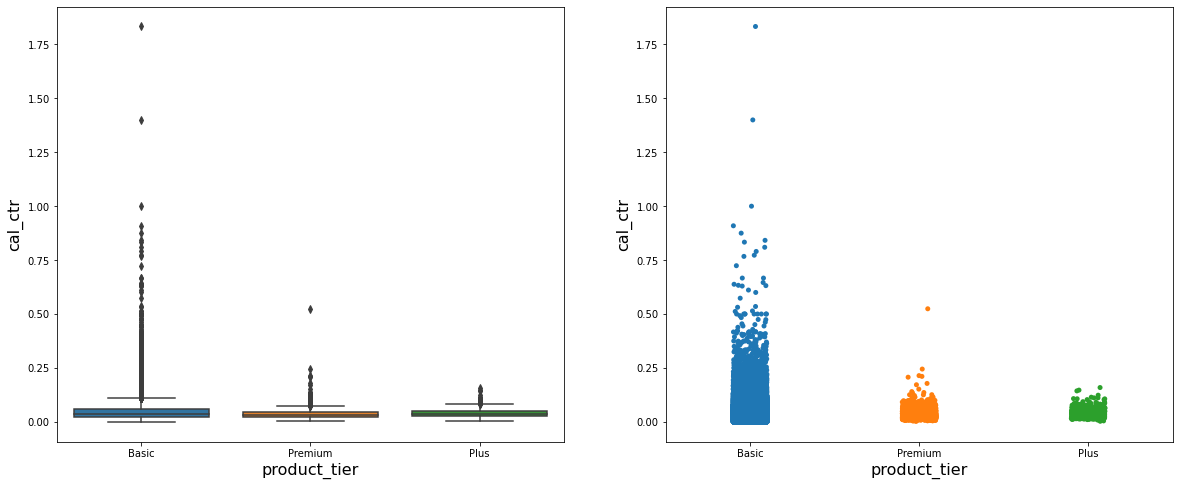

In [15]:
utils_analysis.make_discrete_plot(modified_data, 'product_tier', 'cal_ctr')

#### Relationship between product_tier and price
* From the plot below we can directly reject a common perception that articles in the product_tier Basic need not necessarily be cheaper compared to other categories.
* The vertical spread of the strip plot, particularly along the product_tier Basic shows that price of the article is not the ONLY factor or reason for the low ctr of other categories. 


c:\Users\Shrikanth Singh\Desktop\Next Opportunity\Autoscout24\Assignment\notebooks\utils_analysis.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


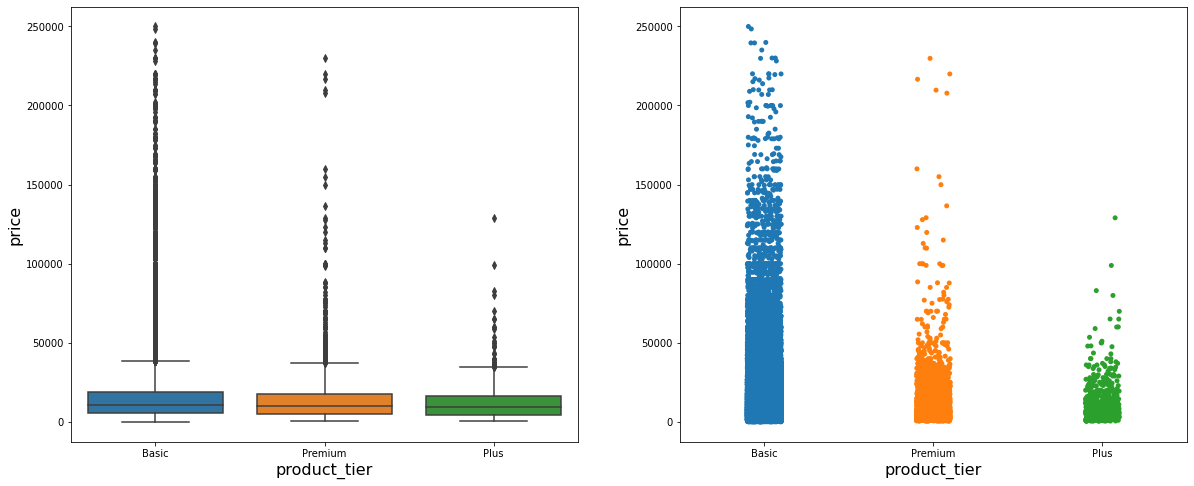

In [16]:
utils_analysis.make_discrete_plot(modified_data, 'product_tier', 'price')

#### Relationship between product_tier and first_registration_year
* The scatter plot below indicates that the category Basic has a very wide collection of articles w.r.t the first_registration_year.
* This variance for the Basic category attracts more visitors yielding higher CTR and understandbly the opposite for other categories.

<AxesSubplot:xlabel='product_tier', ylabel='first_registration_year'>

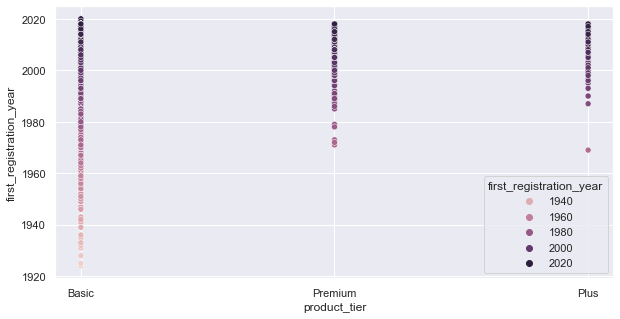

In [17]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.scatterplot(data=modified_data, x=modified_data.product_tier, y='first_registration_year', 
                hue='first_registration_year')

#### Relation between CTR and price
Typical behaviour of the visitor is proven here. 

The high positive skewness and clustering of CTR along the lower price range evidently shows that cheaper articles acquire more detail_views than the expensive ones.

C:\Users\Shrikanth Singh\anaconda3\envs\as24_interview\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


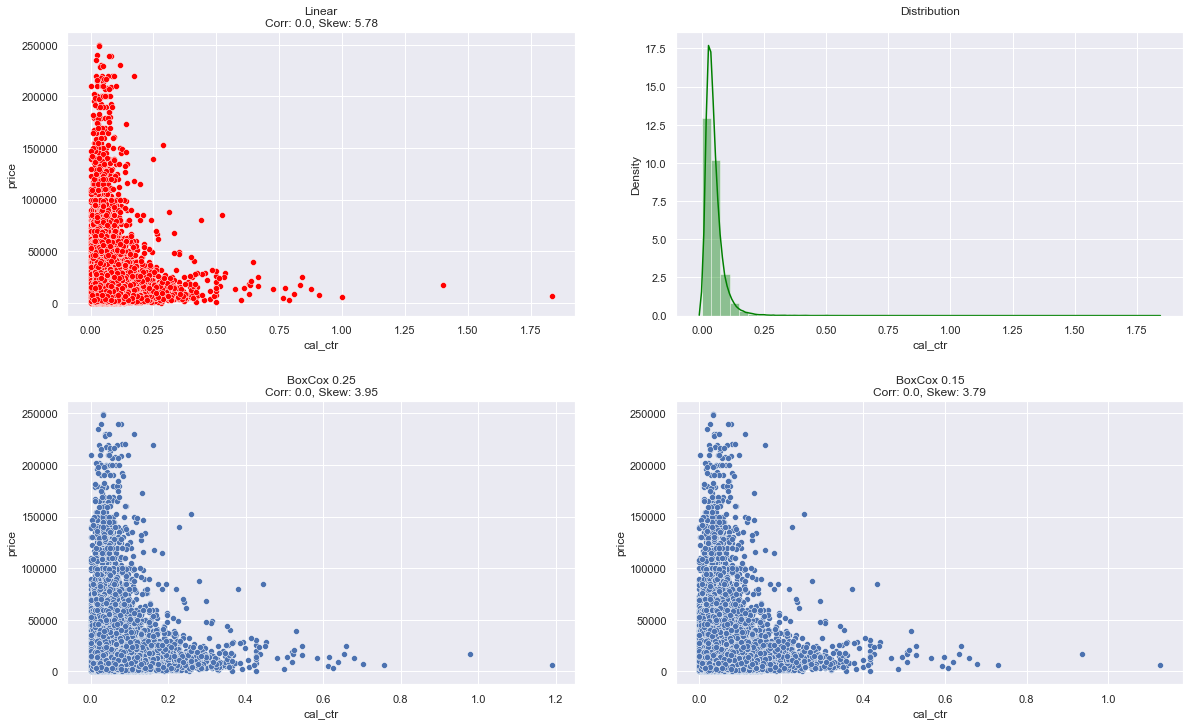

In [18]:
utils_analysis.make_continuous_plot(modified_data, 'cal_ctr', 'price')

#### Relation between product_tier and price - ANOVA

* H0 - Subgroups of product_tier has an effect on the price. H1 - Subgroups of product_tier does not have an effect on the price.
* As there are more than one groups in the product_tier and price being a continuous variable we sought to apply ANOVA test to verify if there is any deviation between the groups w.r.t price.
* Due to unbalanced (unequal sample size for each group) data, we will perform one-way ANOVA with balanced design (equal sample size for each group).
* For the given dataset the ANOVA analysis is significant (pvalue < 0.05) therefore we reject H0 and accept H1. We conclude that product_tier does not have an effect on the price..
* F value is inversely related to p value and higher F value (greater than F critical value) indicates a significant p value.


In [19]:
anova_test_data = modified_data.copy()
anova_test_data = anova_test_data.groupby('product_tier').\
                  head(Counter(modified_data['product_tier'])['Plus'])                 
anova_test_data.product_tier = anova_test_data.product_tier.astype('category').cat.codes

fvalue, pvalue = stats.f_oneway(anova_test_data['product_tier'], anova_test_data['price'])
print(f'Computed F statistic of the test = {fvalue}')
print(f'Associated p-value from the F distribution = {pvalue}')

Computed F statistic of the test = 1346.0679535706752
Associated p-value from the F distribution = 3.775289854824415e-249


#### Relation between make_name and product_tier
* The first bar graph shows the count of product_tier per make from which it is clear that articles from Basic product_tier cover and dominate all the make_name available.
* From the second bar graph we can comprehend the imbalance in the data interms of different make_name per product_tier. Such an imbalance already indicates the bias towards one class while performing classification.

In [20]:
make_vs_tier = modified_data[['product_tier', 'make_name']]
top_10_make = list(make_vs_tier['make_name'].value_counts().head(20).index)
truncated_make_vs_tier = make_vs_tier[make_vs_tier['make_name'].isin(top_10_make)]

<AxesSubplot:xlabel='make_name'>

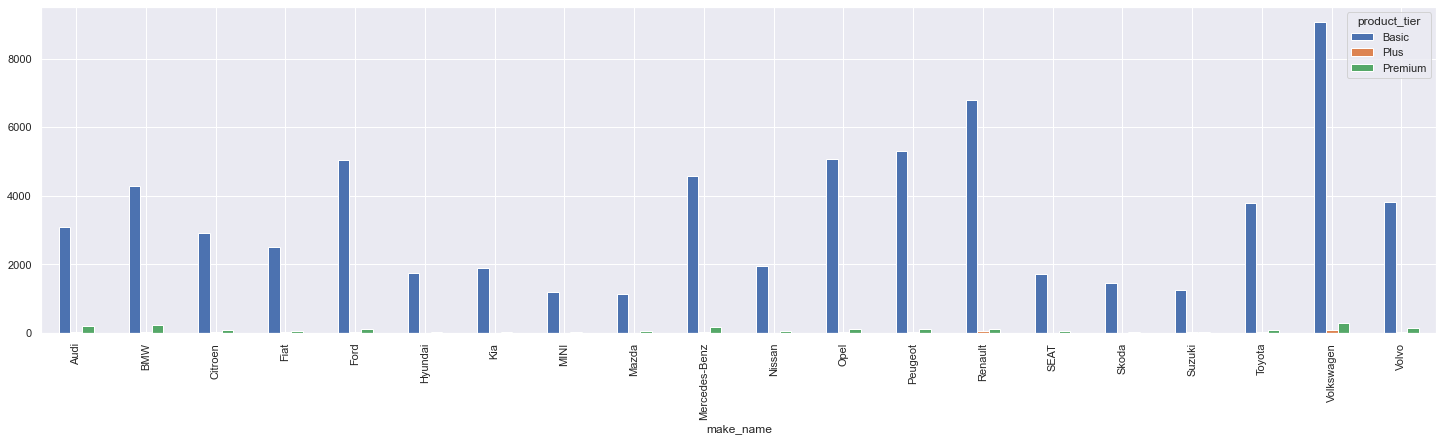

In [21]:
crosstab_result=pd.crosstab(index=truncated_make_vs_tier['make_name'],
                           columns=truncated_make_vs_tier['product_tier'])
crosstab_result.plot(kind="bar", figsize=(25,6), width=0.5)

In [22]:
truncated_make_vs_tier = truncated_make_vs_tier.groupby('product_tier')['make_name'].apply(list).reset_index()
truncated_make_vs_tier['tier_per_make'] = truncated_make_vs_tier['make_name'].apply(lambda x: dict(Counter(x)))

In [23]:
truncated_make_vs_tier = pd.concat([truncated_make_vs_tier.drop(['tier_per_make', 'make_name'], axis=1), 
                                      truncated_make_vs_tier['tier_per_make'].apply(pd.Series)], axis=1)
truncated_make_vs_tier.set_index('product_tier', inplace=True)
truncated_make_vs_tier

,Mercedes-Benz,Ford,Volkswagen,Fiat,Renault,Mazda,Peugeot,Opel,Toyota,Volvo,MINI,Nissan,BMW,Audi,Hyundai,Suzuki,Citroen,Kia,Skoda,SEAT
product_tier,,,,,,,,,,,,,,,,,,,,
Basic,4563,5043,9052,2517,6794,1135,5294,5064,3799,3810,1192,1952,4295,3095,1761,1266,2913,1885,1467,1710
Plus,31,26,77,22,50,16,29,28,32,32,8,14,30,27,9,21,17,10,8,12
Premium,172,130,301,50,112,47,123,126,93,152,34,50,229,191,32,25,87,36,41,51


Text(0, 0.5, 'Count of Make name')

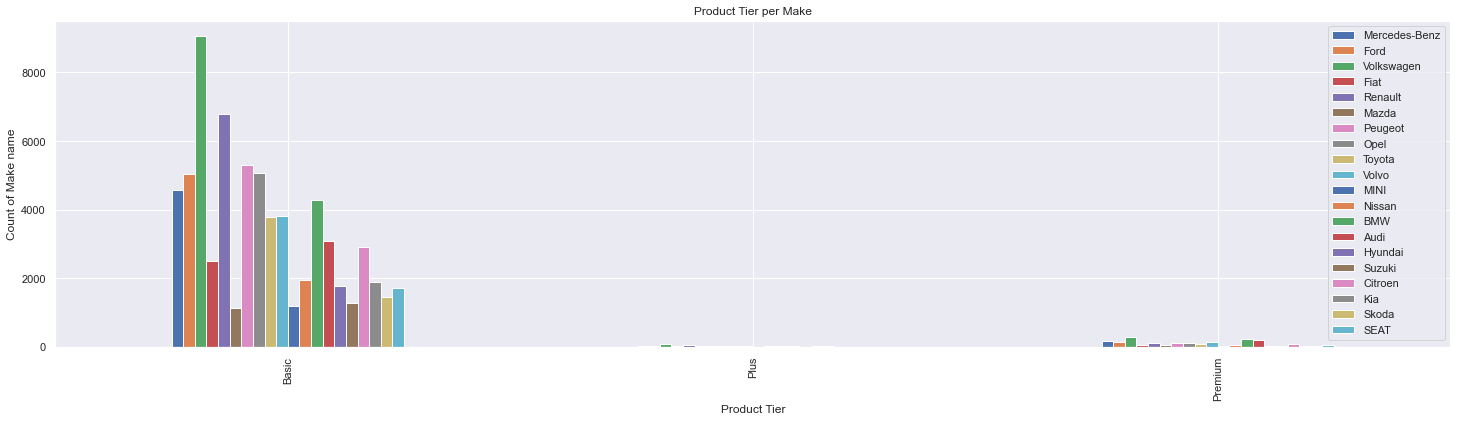

In [24]:
truncated_make_vs_tier.plot(kind="bar", figsize=(25,6), width=0.5)
plt.title("Product Tier per Make")
plt.xlabel("Product Tier")
plt.ylabel("Count of Make name")

#### Correlation Matrix and Conclusion
* All the selected features against the product_tier, individually show minimal correlation (both positive and negative) with each other.
* One crucial observation we can see from the matrix is the correlation between the price and the first_year_registration. This also showcases the obvious fact that articles with older registration have lower price and vice-versa.
* From the coefficients we can see that make_name is most negatively correlated with price and hence has an influence on it.

Due to the highly imbalanced dataset these coefficients can be deceptive and deviating from the actual association between different features. Therefore we will move forward with the available data and persisting imbalance to train a Machine Learning model for predicting the product_tier from the other available features.

In [25]:
data_correlation_check = modified_data[['product_tier', 'make_name', 'price', 'first_zip_digit', 
                                        'first_registration_year', 'stock_days', 'cal_ctr']].copy()

data_correlation_check.product_tier = data_correlation_check.\
                                      product_tier.astype('category').cat.codes
                                      
data_correlation_check.make_name = data_correlation_check.\
                                   make_name.astype('category').cat.codes

data_correlation_check.first_zip_digit = data_correlation_check.\
                                         first_zip_digit.astype('category').cat.codes

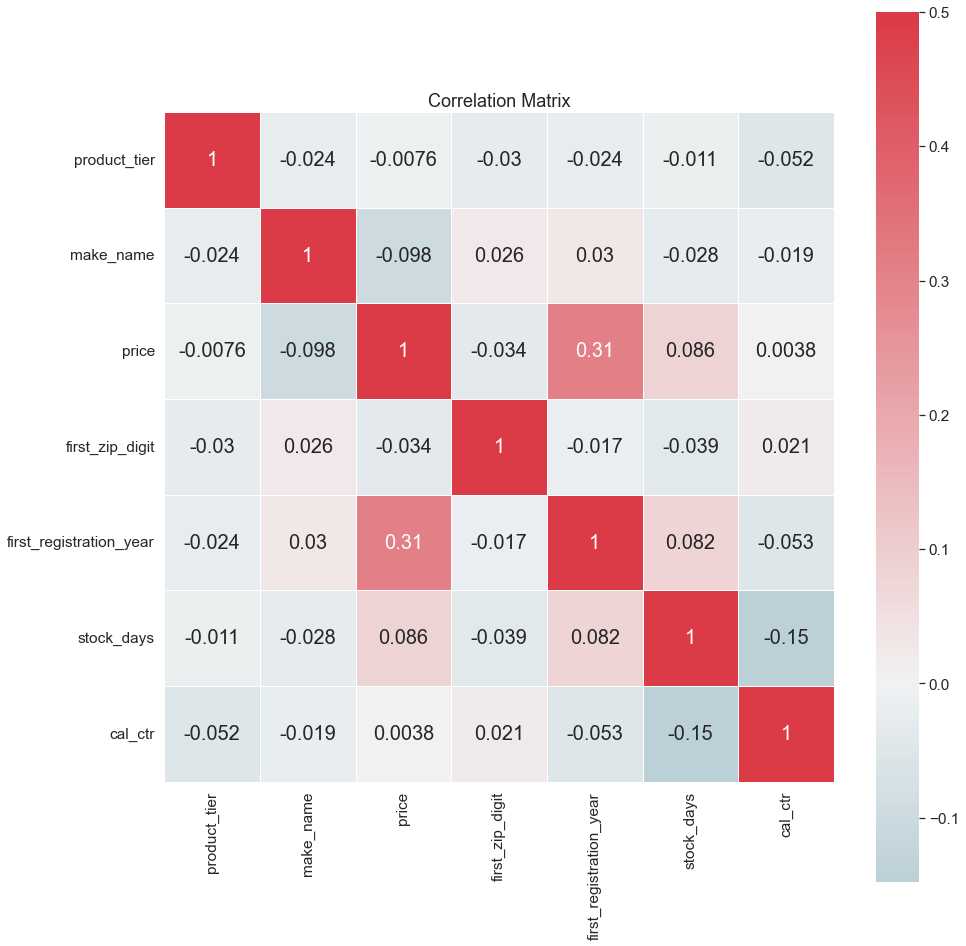

In [26]:
utils_analysis.plot_corr_matrix(data_correlation_check)

#### Conclusion
* Due to the imbalance it is hard to apply certain statistical test, either the dataset has to be downsampled to achieve a balanced design or artificial data points have to be injected.
* Existing imbalance in the dataset w.r.t the product_tier and poor correlation among the features indicate, any classification model will yield good overall accuracy but the developed model will suffer from poor recall and precision.


### Data Analysis 
#### Question 2 - Is it possible to predict detail views from the information given in the other columns?

In [27]:
details_view_analysis = modified_data.copy()

### Preprocessing and Cleaning
* We can witness some values along the column stock days are negative (i.e deleted_date > created_date) and therefore they are discarded. If we can determine the reason then we could tweek the data and minimize the loss of significant amount of samples.
* Additionally we can notice that some articles have search_views = 0 and stock_days = 0 which means the article was posted and taken down immediately. These data points are trivial and hence can be eliminated.
* For the pupose of analysis and explainability we incremented the stock_days by 1 from the existing values so as to include the contribution of the articles having stock_days = 0 (i.e created_date == deleted_date) and search_views > 0.

In [28]:
details_view_analysis.dropna(subset=['detail_views', 'search_views'], inplace=True)
details_view_analysis.drop(\
                           details_view_analysis[details_view_analysis['stock_days'] < 0].index, 
                           inplace=True)
 
details_view_analysis.drop(details_view_analysis \
    [(details_view_analysis['search_views']==0.0) & \
    (details_view_analysis['stock_days']==0.0)].index, inplace=True)

details_view_analysis['stock_days'] += 1

details_view_analysis.to_csv(os.path.join('..', 'data', 'AS24_prepro_data_detail_views.csv'), 
                             index=False)

### Relation between search_views and detail_views

#### Correlation and Skewness Plot
* A very high correlation is observed between the search_views and detail_views. Therefore we can postulate as24 is providing significantly good suggestions based on the filters selected by the visitors.

* Since the website as24 does not have a search dialog box but rather has detailed filter options the search_views can theoretically be considered as impressions.

* In this scenario there is higher probability of a search_view being converted to detail_view eventually boosting the ctr. The magnitude of this probability can be understood from skewness value which is extremly high and the same value drops drastically after applying boxcox transformation. 

* In my perspective a more sophisticated and organic approach would be to include the position of product as a correction factor for the CTR calculation.

#### Regression plot
* From the regression plot between the search_views and detail_views we can see that the confidence area (variance) around the best fit line is very narrow indicating the interdependence between the variables. 
* But this high dependence can turn out to be a set back when combined with other features and therefore additional care has to be taken to avoid redundancy. 
* https://stats.stackexchange.com/questions/13487/what-does-this-blur-around-the-line-mean-in-this-graph 

C:\Users\Shrikanth Singh\anaconda3\envs\as24_interview\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


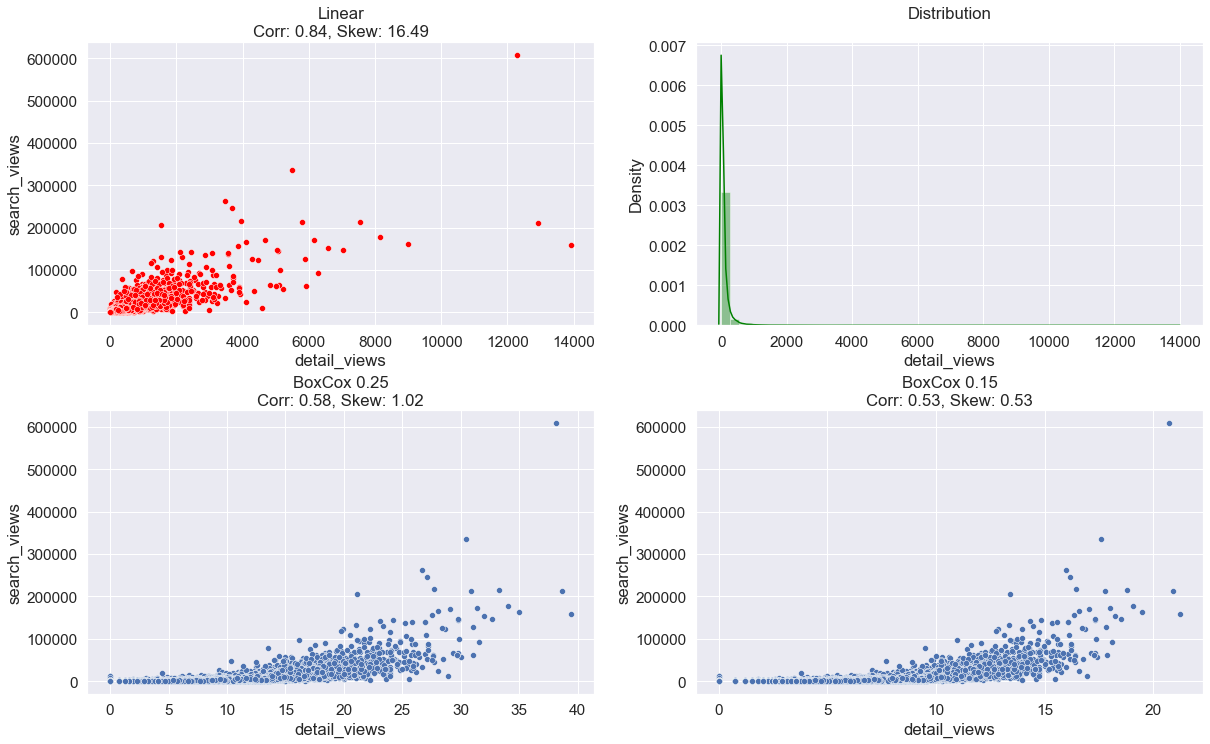

In [29]:
utils_analysis.make_continuous_plot(details_view_analysis, 
                                    'detail_views', 
                                    'search_views')

In [30]:
utils_analysis.calculate_pear_coeff(details_view_analysis, 
                                    'detail_views', 
                                    'search_views')

Pearsons correlation between detail_views and search_views: 0.836


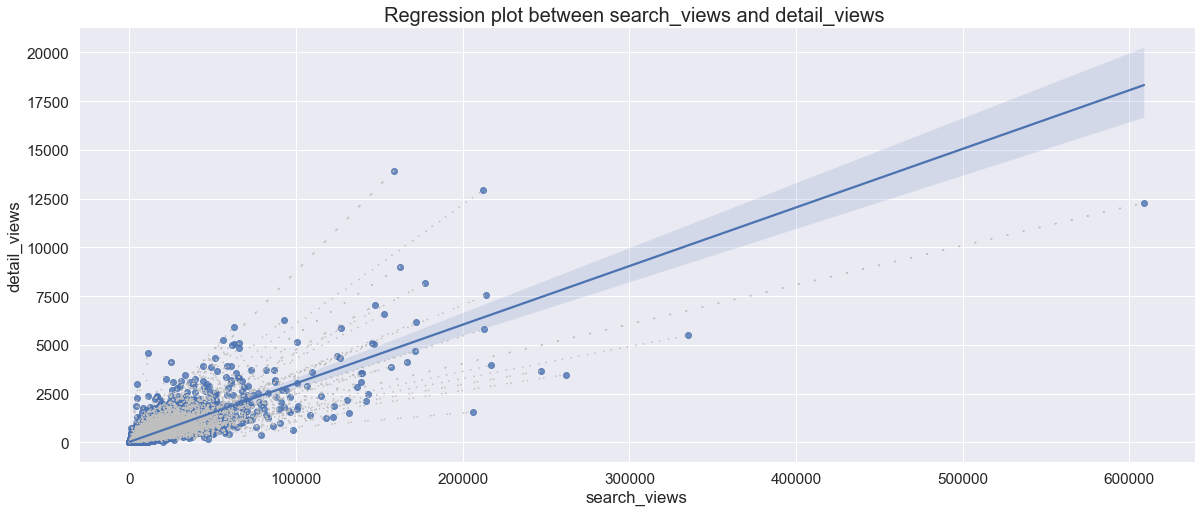

In [31]:
#https://stats.stackexchange.com/questions/13487/what-does-this-blur-around-the-line-mean-in-this-graph
utils_analysis.make_reg_plot(details_view_analysis, 
                             'search_views', 
                             'detail_views')

### Relation between stock_days and detail_views
* From the scatter plot we can distinctly see some significant red spots above the 4000 mark as the stock_days increases over 40. This indicates that the articles listed for more than 2 months are still relevant to the visitors and it will be interesting to know the conversion of these articles to being purchased (or leased).

* The normal distribution of detail_views between stock_days > 40 and stock_day < 60 will act as a significant feature to predict the detail_views of the articles. In contrast the density of detail_views tails out in then end and it can aid it distinguishing the group of articles at a node in the decision tree.

* From the regression plot we can discern that at the low detail_views the points are highly populated along the stock_days axis and therefore this feature individually will not add importance to the model.

C:\Users\Shrikanth Singh\anaconda3\envs\as24_interview\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


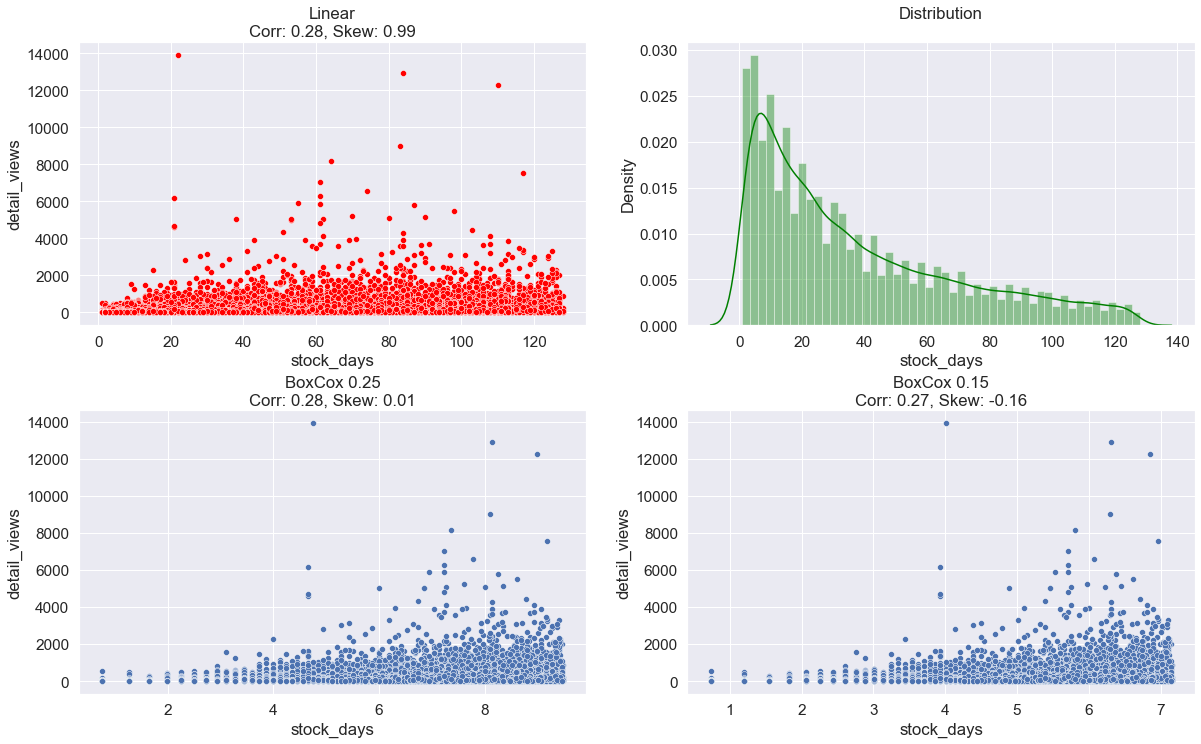

In [32]:
utils_analysis.make_continuous_plot(details_view_analysis, 
                                    'stock_days', 
                                    'detail_views')

In [33]:
utils_analysis.calculate_pear_coeff(details_view_analysis, 
                                    'stock_days', 
                                    'detail_views')

Pearsons correlation between stock_days and detail_views: 0.281


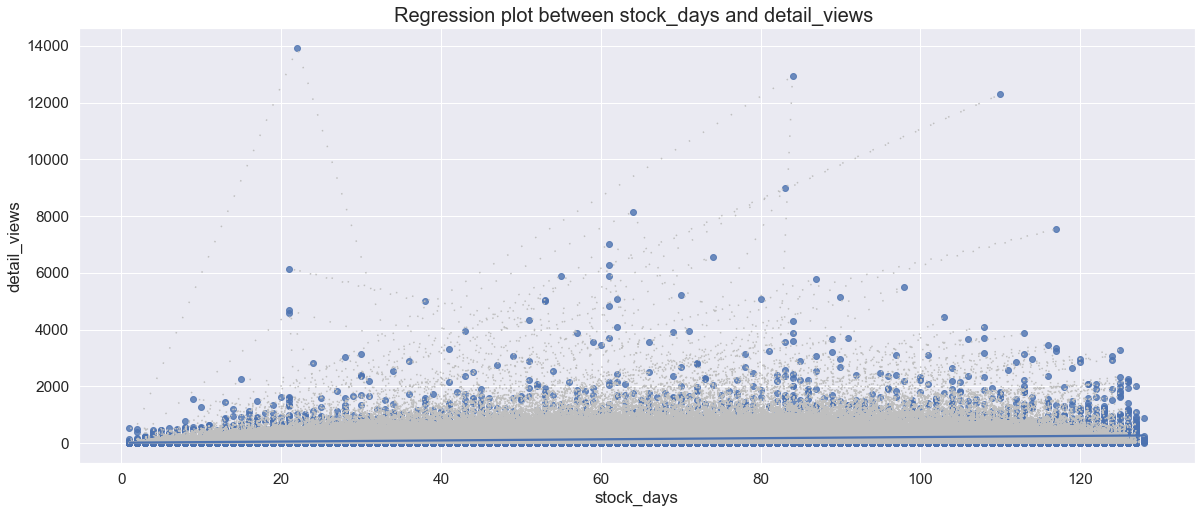

In [34]:
utils_analysis.make_reg_plot(details_view_analysis, 
                             'stock_days', 
                             'detail_views')

### Relation between search_views_per_stock_day and detail_views_per_stock_day
There is no drastic change in the insights to be explained here w.r.t to the search_views and detail_views analysis above. 

In [35]:
details_view_analysis['search_view_per_day'] = details_view_analysis['search_views'] /\
                                               details_view_analysis['stock_days']
                                               
details_view_analysis['detail_view_per_day'] = details_view_analysis['detail_views'] /\
                                               details_view_analysis['stock_days']

In [36]:
utils_analysis.calculate_pear_coeff(details_view_analysis, 
                                    'search_view_per_day', 
                                    'detail_view_per_day')

Pearsons correlation between search_view_per_day and detail_view_per_day: 0.717


C:\Users\Shrikanth Singh\anaconda3\envs\as24_interview\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


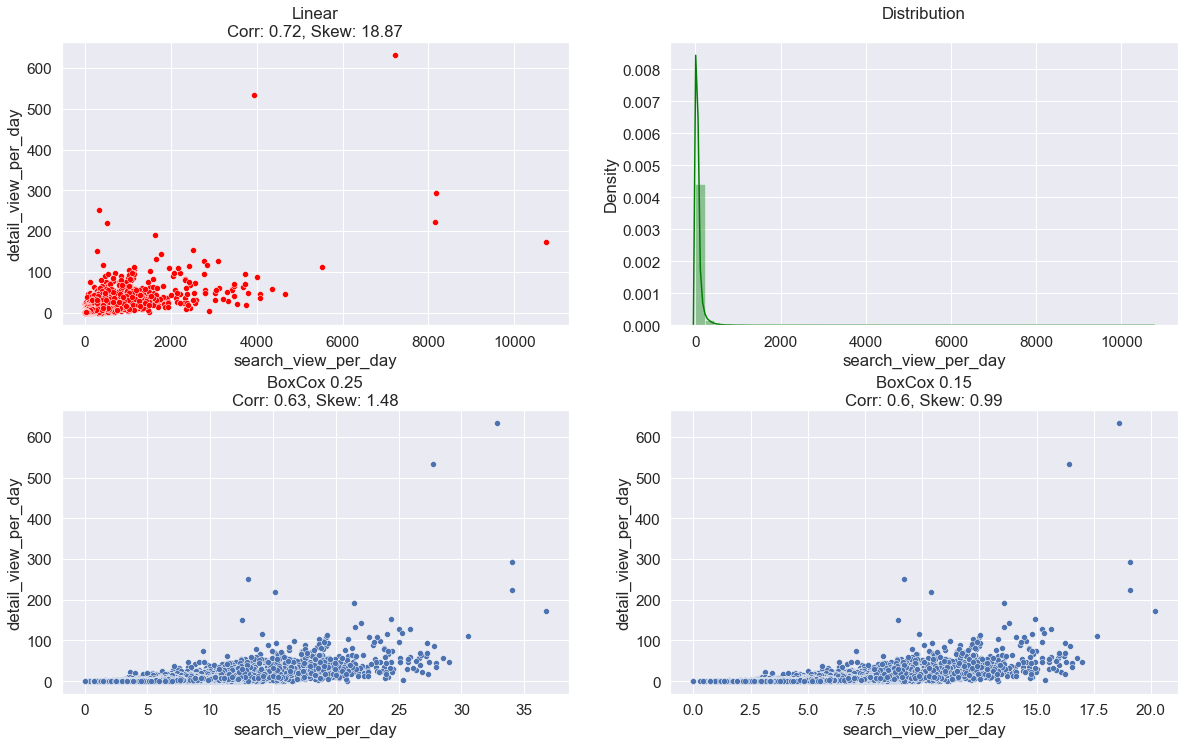

In [37]:
utils_analysis.make_continuous_plot(details_view_analysis, 
                                    'search_view_per_day', 
                                    'detail_view_per_day')

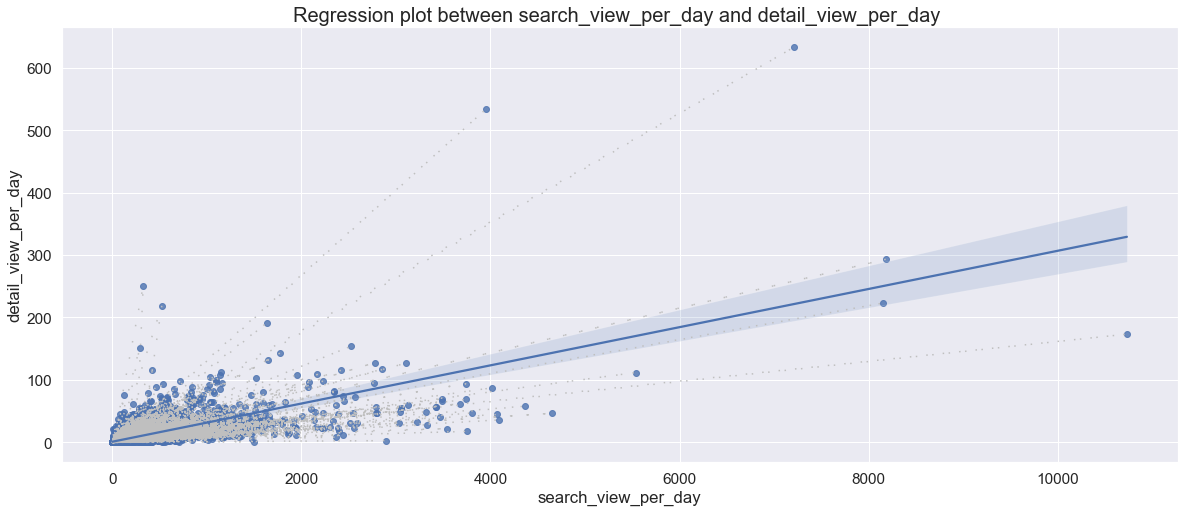

In [38]:
utils_analysis.make_reg_plot(details_view_analysis, 
                             'search_view_per_day', 
                             'detail_view_per_day')

### Relationship between price and detail_views
* Very less correlation and slight skewness between price and detail_views shows that price is not a limiting factor for the visitors to choose their desired product. 
* The gaussian distribution from the pdf plot for the price range 0 to 50000 shows the diversity of visitors on as24.

C:\Users\Shrikanth Singh\anaconda3\envs\as24_interview\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


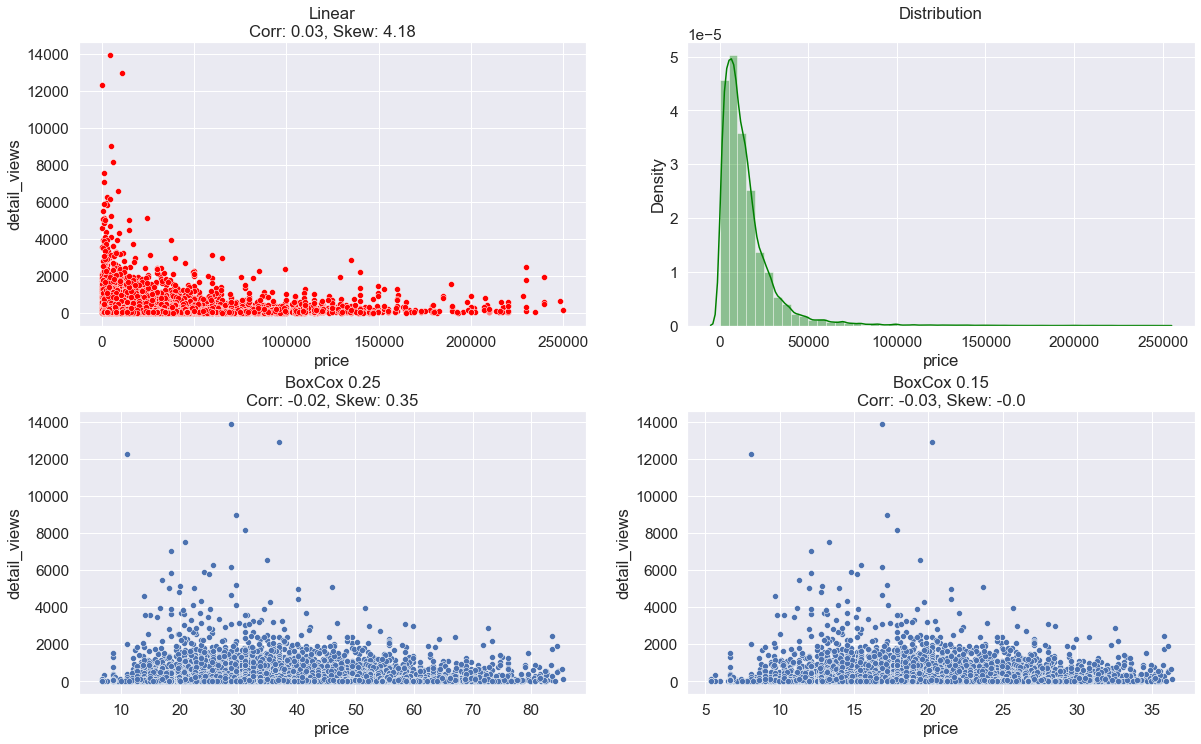

In [39]:
utils_analysis.make_continuous_plot(details_view_analysis, 
                                    'price', 
                                    'detail_views')

In [40]:
utils_analysis.calculate_pear_coeff(details_view_analysis, 
                                    'price', 
                                    'detail_views')

Pearsons correlation between price and detail_views: 0.029


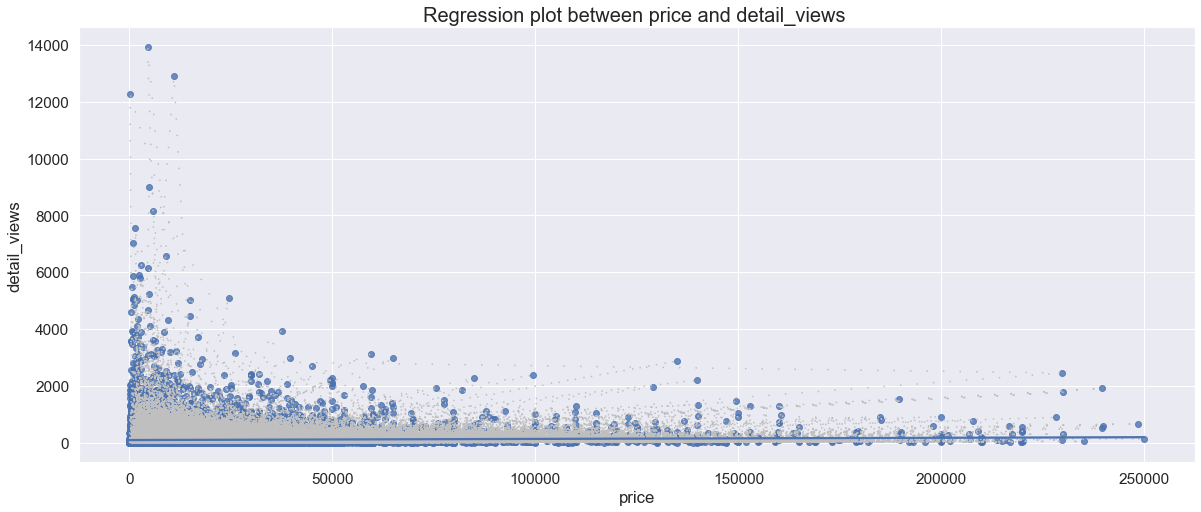

In [41]:
utils_analysis.make_reg_plot(details_view_analysis, 
                             'price', 
                             'detail_views')

### Correlation and Conclusion
* Very high negative correlation between first_year_registration adn detail_views shows the orientation of the visitors. The visitors are more likely looking for recently registered cars inspite of higher price.

* The product_tier is playing a vital role in influencing the detail_view clicks per article, but this assumption cannot be accepted to the fullest because of imbalanced data samples in the product_tier class.

* There should have been non-trivial level of correlation between the make_name and detail_views but as we noticed in the above analysis the product_tier Basic covers most of the make_names when compared to Plus and Premium class groups.

* Using ctr will lead to data leakage because of the its formula. Therefore we will not include it in the feature set.

In [42]:
corr_detail_view = details_view_analysis[['detail_views', 'product_tier', 'make_name', 
                                          'first_zip_digit', 'first_registration_year']].copy()
                                          
corr_detail_view.product_tier = corr_detail_view.\
                                product_tier.astype('category').cat.codes
                                
corr_detail_view.make_name = corr_detail_view.\
                             make_name.astype('category').cat.codes

corr_detail_view.first_zip_digit = corr_detail_view.\
                                   first_zip_digit.astype('category').cat.codes

corr_detail_view.first_registration_year = corr_detail_view.\
                                           first_registration_year.astype('category').cat.codes

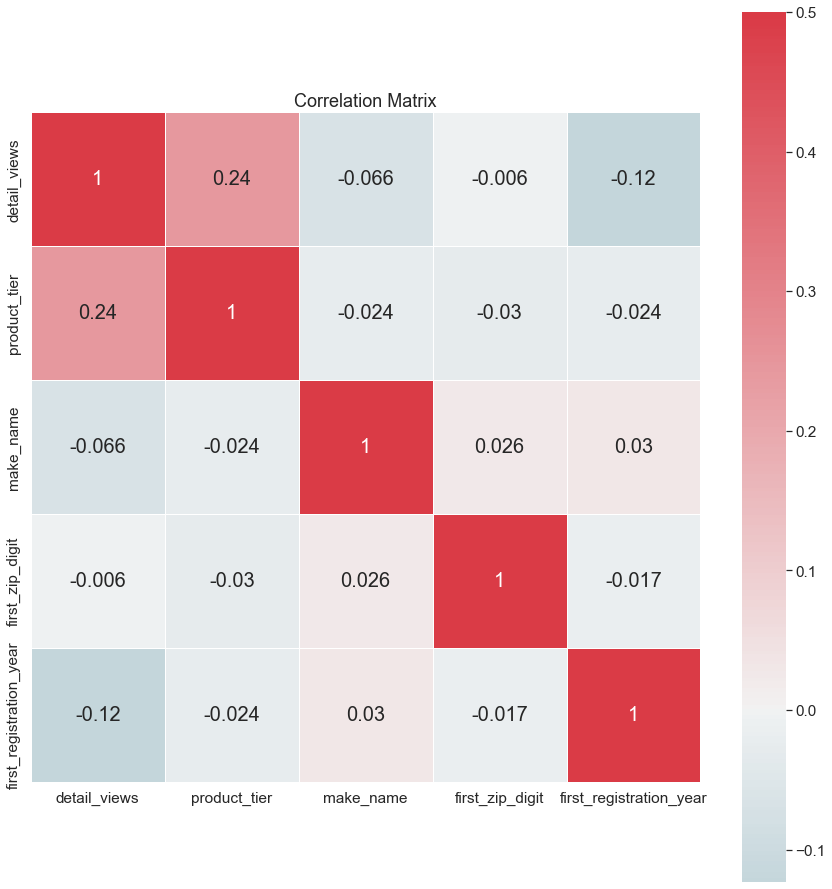

In [43]:
utils_analysis.plot_corr_matrix(corr_detail_view)

### Could have been done
* If the data about:

    1. Impressions
    2. Judgement scores
    3. Product position
    4. Price momentum
    5. Facets that resulted in conversion of search view to detail views

Were provided it could have amplified the performance of the model in predicting the detail views more accurately.

* Detail views per day is highly dependent on search views per day, this correlation can be used in a time series to predict the products that would result in more detail views using their search views from t-n steps.
